In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
#
import matplotlib.colors as mplc
import matplotlib.pyplot as plt
#
from farrow_and_ball import *
from numpy.linalg import eigvals
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from scipy.linalg import expm
from scipy.spatial.distance import squareform

In [150]:
# stochastic block model parameters
N1 = N2 = 10
sizes = [N1, N2]
probs = [[0.95, 0.05], [0.05, 0.95]]

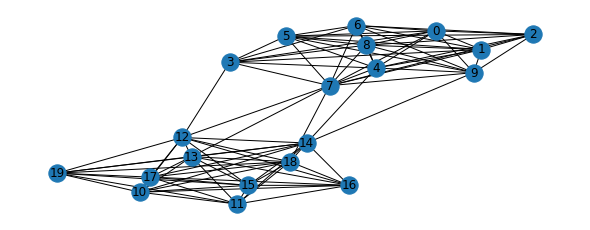

In [151]:
G = nx.stochastic_block_model(sizes, probs, seed=0)
labelList = [i for i in range(G.number_of_nodes())]
plt.figure(figsize=(8,3)) 
nx.draw(G, node_size=300, with_labels = True)

In [152]:
# utils
tresh = 0.1
dentroOpts = {'leaf_rotation': 0, 
              'orientation': 'right', 
              'color_threshold': tresh,
              'above_threshold_color': 'k',
              'leaf_font_size': 10,
              'labels': labelList}

In [154]:
# laplacian, spectrum and densities
L = nx.laplacian_matrix(G).todense()
w = 1. / nx.laplacian_spectrum(G)
tau = w[10]
num = expm((-tau*L))
den = np.trace(num)
rho = num/den
Trho = np.copy(1. / rho)
Trho = np.maximum(Trho, Trho.T)
np.fill_diagonal(Trho, 0)
dists = squareform(Trho)
linkage_matrix1 = linkage(dists, "average")
tmax = linkage_matrix1[::, 2][-1]
linkage_matrix = linkage(dists/tmax, "average")
#
tmin = linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
print(w)

[-1.47074653e+14  1.06606383e+00  1.33192061e-01  1.25000000e-01
  1.15370614e-01  1.08027959e-01  1.00000000e-01  1.00000000e-01
  1.00000000e-01  1.00000000e-01  1.00000000e-01  1.00000000e-01
  1.00000000e-01  1.00000000e-01  9.79512394e-02  9.28928066e-02
  9.09090909e-02  8.63596617e-02  8.05121392e-02  7.32321293e-02]


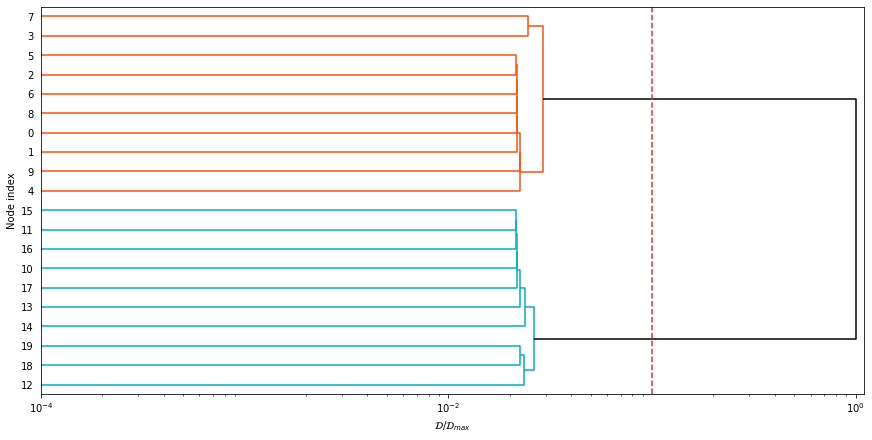

In [109]:
ax_dict = plt.figure(constrained_layout=True,
                     figsize=(12, 6)).subplot_mosaic("A")

ax_dict['A'].set_xlabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
ax_dict['A'].set_ylabel('Node index')

dendrogram(linkage_matrix, ax=ax_dict['A'], **dentroOpts)
CM = fcluster(linkage_matrix, t=tresh, criterion='distance')
cmap = build_colormap(MiscPalette.TONKA, True)
cmap1 = cmap(np.linspace(0, 1, np.max(CM)))
cmap1[0] = [0., 175/255., 187/255., 1.]
cmap1[1] = [252/255., 78/255., 7/255., 1.]

hierarchy.set_link_color_palette([mplc.rgb2hex(rgb[:3]) for rgb in cmap1])

ax_dict['A'].axvline(x=tresh, c='#ED2939', ls='--')
ax_dict['A'].set_xlim(tmin, tmax)
ax_dict['A'].set_xscale('log')
ax_dict['A'].set_xticks([1e-4, 1e-2, 1e0])
plt.show()

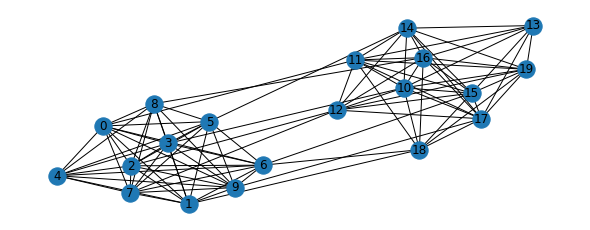

In [155]:
# stochastic block model with subpartition
G = nx.stochastic_block_model(sizes, probs, seed=1)

for edge in G.edges():
    G.add_edge(edge[0], edge[1], weight=1)
    sign = G.get_edge_data(edge[0], edge[1])

plt.figure(figsize=(8,3)) 
nx.draw(G, node_size=300, with_labels = True)

H = nx.quotient_graph(G, G.graph["partition"], relabel=False)

community1 = list(list(H.nodes())[0])
sub_community1 = community1[:len(community1)//2]
sub_community2 = community1[len(community1)//2:]
for vertex in sub_community1:
    for edge in G.edges(vertex):
        if edge[1] in sub_community2:
            G[edge[0]][edge[1]]['weight'] =-1

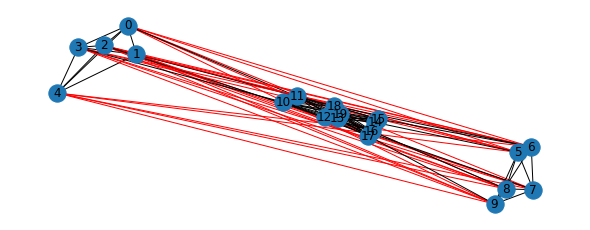

In [156]:
colors = ['r' if G[u][v]['weight'] == -1 else 'k' for u,v in G.edges()]
plt.figure(figsize=(8,3)) 
nx.draw(G, edge_color=colors, node_size=300, with_labels = True)

In [157]:
# laplacian, spectrum and densities
A = nx.adjacency_matrix(G).toarray()
D = np.diag(np.abs(A).sum(axis=1)) 
L = D-A
w = 1. / eigvals(L)
tau = w[10]
num = expm((-tau*L))
den = np.trace(num)
rho = num/den
Trho = np.copy(1. / rho)
Trho = np.maximum(Trho, Trho.T)
np.fill_diagonal(Trho, 0)
old_d = squareform(Trho)
dists = np.max(old_d) - old_d
linkage_matrix1 = linkage(dists, "average")
tmax=linkage_matrix1[::, 2][-1]
linkage_matrix = linkage(dists/tmax, "average")
#
tmin = linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
print(w)

[1.42666831 0.93642788 0.1413876  0.12921462 0.11159364 0.10611984
 0.08101123 0.08210141 0.08333333 0.0844851  0.08528474 0.08635531
 0.08823809 0.08952961 0.09457654 0.09715216 0.1        0.1
 0.1        0.1       ]


/tmp/ipykernel_6207/3139207288.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).toarray()


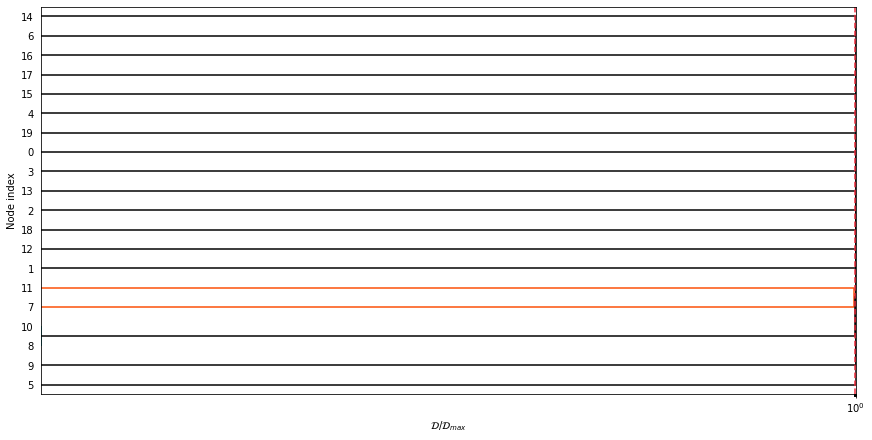

In [149]:
ax_dict = plt.figure(constrained_layout=True,
                     figsize=(12, 6)).subplot_mosaic("A")

dendrogram(linkage_matrix,labels=labelList,ax=ax_dict['A'],leaf_rotation=0,orientation='right',color_threshold=tresh,above_threshold_color='k',leaf_font_size=10)
CM=fcluster(linkage_matrix, t=tresh, criterion='distance')
cmap = build_colormap(MiscPalette.TONKA, True)
cmap1 = cmap(np.linspace(0, 1, np.max(CM)))
cmap1[0]=[0., 175/255., 187/255., 1.]
cmap1[1]=[252/255., 78/255., 7/255., 1.]
hierarchy.set_link_color_palette([mplc.rgb2hex(rgb[:3]) for rgb in cmap1])
ax_dict['A'].axvline(x = tresh, color = '#ED2939', linestyle = '--')
tmin=linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax=linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
ax_dict['A'].set_xlim(tmin,tmax)
ax_dict['A'].set_xlabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
ax_dict['A'].set_ylabel('Node index')
ax_dict['A'].set_xscale('log')
ax_dict['A'].set_xticks([1e0])


plt.show()